In [36]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
from tqdm import tqdm, tqdm_notebook

%run ../Scripts/immunity.py
%run ../Scripts/altimmunity.py
%run ../Scripts/initMethods.py
%run ../Scripts/randomHGT.py

In [46]:
params = { #parameters relevant for the equations
    "Nh":                  10000,
    "N0":                  10000,
    "M":                       3, #Also L, total number of spacers
    "beta":                    1,
    "rate_HGT":              1/10,
    "HGT_bonus_acquisition": 1000, 
    "recovery_time":            5,
    }
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "dt":                           1,
    "xdomain":                    300,
    "dx":                           1,
    "initial_mean_n":         [0,-100],
    "initial_var_n":               40,
    "initial_mean_nh":         [0,150],
    "initial_var_nh":              40,
    "num_threads":                  4,
    "tail_axis":               [1, 1],
    "conv_size":                2000,
    }

In [27]:
nh0 = init_guassian(params["Nh"]*params["M"], sim_params, "nh")

n0 = init_guassian(params["N0"], sim_params, "n")

In [28]:
np.sum(nh0)

30000

In [29]:
Nh = params["Nh"]
N = np.sum(n0)
num_threads = sim_params["num_threads"]

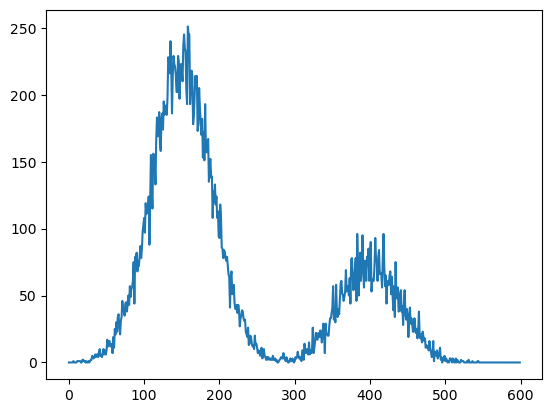

In [30]:
params["beta"] = 0.0000001
guassian_kernel = init_quarter_kernel(params, sim_params, type = "beta", exponent=2)
nh_intergrated = immunity_gain_from_kernel(nh0, n0, guassian_kernel, params, sim_params)
nh_new = immunity_loss_uniform(nh_intergrated, n0, params, sim_params)
flat_nh_new = np.array(np.sum(nh_new.todense(), axis = 0)).squeeze()
plt.plot(flat_nh_new, label = f"beta = {0}")

In [31]:
np.sum(nh_intergrated)

40000

In [32]:
np.sum(nh_new)

30000

In [41]:
current_time = 10
time2next_event = get_time_next_HGT(current_time, params, sim_params)
time2next_event

array([19.52564853])

In [47]:
num_to_add = np.sum(n0) + params["HGT_bonus_acquisition"]
num_to_remove = np.sum(n0)

timesteps_to_recovery = np.ceil(params["recovery_time"]/sim_params["dt"])
counter_to_recovery = timesteps_to_recovery

params["M"] = params["M"] + params["HGT_bonus_acquisition"]/params["Nh"]

num_to_add = np.sum(n0) - params["HGT_bonus_acquisition"]*(1/timesteps_to_recovery)
num_to_remove = np.sum(n0)
params["M"] = params["M"] - (params["HGT_bonus_acquisition"]/params["Nh"])*(1/timesteps_to_recovery)

counter_to_recovery -= 1

In [66]:
%run ../Scripts/coverage.py
%run ../Scripts/fitness.py
%run ../Scripts/immunity.py
%run ../Scripts/initMethods.py
%run ../Scripts/supMethods.py
%run ../Scripts/mutation.py
%run ../Scripts/altImmunity.py

In [85]:
params = { #parameters relevant for the equations
    "Nh":                  10000,
    "N0":                   1000, #This Will be updated by self-consitent solution
    "R0":                    20, 
    "M":                       5, #Also L, total number of spacers
    "mu":                   0.01, #mutation rate
    "gamma_shape":            20, 
    "Np":                     10, #Number of Cas Protein
    "dc":                      3, #Required number of complexes to activate defence
    "h":                       4, #coordination coeff
    "r":                    2000, #cross-reactivity kernel
    "beta":                 0.000,
    "rate_HGT":              1/10,
    "HGT_bonus_acquisition": 1000, 
    "recovery_time":            5,
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "continue":                 False, #DO NOT CREATE ARBITRARY FOLDERS ONLY FOR TESTS
    "xdomain":                    500,
    "dx":                           1,
    "tf":                          50,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_mean_nh":          [0,0],
    "conv_size":                  500,
    "num_threads":                  1,
    "t_snapshot":                  10,
    "initial_mean_n":         [0,-100],
    "initial_var_n":               40,
    "initial_mean_nh":         [0,150],
    "initial_var_nh":              40,
}

In [86]:
n = init_guassian(params["N0"]*params["M"], sim_params, "n")
nh = init_guassian(params["Nh"], sim_params, "nh")
kernel_quarter = init_quarter_kernel(params, sim_params)
kernel_exp = init_quarter_kernel(params, sim_params, type="Boltzmann")

In [87]:
t = 0
time2nextevent = get_time_next_HGT(t, params, sim_params)
timesteps_to_recovery = np.ceil(params["recovery_time"]/sim_params["dt"])
N_data = []
Nh_data = []
to_add_data = []
time = []


while(t < sim_params["tf"]):
    p = elementwise_coverage(nh, n, kernel_quarter, params, sim_params)

    f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    f = norm_fitness(f, n, params, sim_params) #renormalize f
    n = virus_growth(n, f, params, sim_params) #update

    n = mutation(n, params, sim_params)
    
    if t > time2nextevent:
        num_to_add = np.sum(n0) + params["HGT_bonus_acquisition"]
        num_to_remove = np.sum(n0)
        params["M"] = params["M"] + params["HGT_bonus_acquisition"]/params["Nh"]
        counter_to_recovery = timesteps_to_recovery

    elif counter_to_recovery > 0:
        num_to_add = np.sum(n0) - params["HGT_bonus_acquisition"]*(1/timesteps_to_recovery)
        num_to_remove = np.sum(n0)
        params["M"] = params["M"] - (params["HGT_bonus_acquisition"]/params["Nh"])*(1/timesteps_to_recovery)
        counter_to_recovery -= 0

    else:
        num_to_add = np.sum(n)
        num_to_remove = np.sum(n)
        counter_to_recovery -= 0


    nh_gain = immunity_gain_from_kernel(nh, n, kernel_exp, params, sim_params, num_to_add) #update nh
    nh = immunity_loss_uniform(nh_gain, n, params, sim_params, num_to_remove)

    time.append(t)
    Nh_data.append(np.sum(nh))
    N_data.append(np.sum(n))
    to_add_data.append(num_to_add)

    t += sim_params["dt"]